# 1. Preparing Data

In [ ]:
%pip install labelme tensorflow opencv-python albumentations

In [6]:
#Import Packages
import os
import time
import uuid
import cv2

In [4]:
#Specify Image Path to Store Image Data
IMAGES_PATH = os.path.join('data', 'images')

#Specify Number of Images Taken At Once
number_images = 30

In [ ]:
#Connect to Webcam
cap = cv2.VideoCapture(1)

#For each photo
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    #Take Photo
    ret, frame = cap.read()
    #Create Image Name
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    #Write Image
    cv2.imwrite(imgname, frame)
    #Display Image On Screen
    cv2.imshow('frame', frame)
    #Delay 0.5 Seconds To Take Next Photo. Can Also Be Configured To Take Manually
    time.sleep(0.5)

    #Break Condition
    if(cv2.waitKey(1) & 0xFF == ord('q')):
        break

#Release Hardware Resource
cap.release()

#Close Window
cv2.destroyAllWindows()

Use Labelme Software To Label Data

In [16]:
!labelme

2024-08-05 19:40:25,563 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\ethan\.labelmerc


# 2. Review Dataset and Build Image Loading Function

In [5]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## Use GPU If Possible, But Used CPU Here

In [24]:
#Load Image Into TF Data Pipeline
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [25]:
#Check that Images Are Working
images.as_numpy_iterator().next()

b'data\\images\\fc9958a3-5383-11ef-85b4-f0761c196e1d.jpg'

In [26]:
#Load Image Function
def load_image(x):
    #Read File From File Path and Return Byte Encoded Image
    byte_img = tf.io.read_file(x)
    #Decode Byte Image
    img = tf.io.decode_jpeg(byte_img)
    return img

In [27]:
#Load All Images Using Tensorflow Pipeline
images = images.map(load_image)

In [ ]:
#Check All Images
images.as_numpy_iterator().next()

In [30]:
#View Raw Images with Matplotlib
#Form Batches of Images
image_generator = images.batch(4).as_numpy_iterator()

In [31]:
#Load Next Batch
plot_images = image_generator.next()

In [ ]:
#Load 4 Figures with size 20x20
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
#Display Each Image
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
#Display Plot
plt.show()

# 3. Partition Unaugmented Data

In [62]:
random_state = 42

In [58]:
from sklearn.model_selection import train_test_split

#Extract All File Names From Image Folder
image_files = [f for f in os.listdir(os.path.join("data", "images"))]

#Perform Train, Test, Val Split
train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=random_state)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=random_state)

['bbe455bd-5383-11ef-8bb0-f0761c196e1d.jpg', 'bf16f409-5383-11ef-a10b-f0761c196e1d.jpg', '6ac7a9aa-5383-11ef-a891-f0761c196e1d.jpg', '8d70428c-5383-11ef-9331-f0761c196e1d.jpg', 'fc45a6dd-5383-11ef-86e5-f0761c196e1d.jpg', 'bdcc1aaf-5383-11ef-972e-f0761c196e1d.jpg', '70c648b7-5383-11ef-b5cd-f0761c196e1d.jpg', '91e9cfa9-5383-11ef-a5d8-f0761c196e1d.jpg', 'c2f98e77-5383-11ef-a6ae-f0761c196e1d.jpg', '69847ecc-5383-11ef-9b9d-f0761c196e1d.jpg', 'c0b97cc7-5383-11ef-8956-f0761c196e1d.jpg', 'bd7a73a1-5383-11ef-b0c4-f0761c196e1d.jpg', '8f5f6ab0-5383-11ef-816e-f0761c196e1d.jpg', '928f1b44-5383-11ef-8d67-f0761c196e1d.jpg', '8e1459b4-5383-11ef-adf6-f0761c196e1d.jpg', '6cfda0d3-5383-11ef-9d17-f0761c196e1d.jpg', 'bcd744cc-5383-11ef-9182-f0761c196e1d.jpg', '8dc1d1bb-5383-11ef-8127-f0761c196e1d.jpg', 'c34dff93-5383-11ef-9271-f0761c196e1d.jpg', '6a23b5cc-5383-11ef-a0a9-f0761c196e1d.jpg', '90a79e84-5383-11ef-ae38-f0761c196e1d.jpg', 'fbf1b775-5383-11ef-bdf4-f0761c196e1d.jpg', 'c1091db7-5383-11ef-83e2-f0761c

In [56]:
import shutil

#Function to move files
def move_files(file_list, dest_dir):
    for file_name in file_list:
        source_path = os.path.join("data", "images", file_name)
        dest_path = os.path.join("data", dest_dir, "images", file_name)
        shutil.move(source_path, dest_path)

In [59]:
#Move Files Into Respective Folders
move_files(train_files, "train")
move_files(test_files, "test")
move_files(val_files, "val")

In [61]:
#Move Labels To Match  Images
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        #Get UUID
        filename = file.split('.')[0] + '.json'

        #File Path
        existing_filepath = os.path.join('data','labels', filename)

        #Check if File Path Exists
        if os.path.exists(existing_filepath):
            #New File Path
            new_filepath = os.path.join('data', folder, 'labels', filename)
            #Move File Over
            os.replace(existing_filepath, new_filepath)

# 4. Apply Image Augmentation on Images and Label Using Albumentations

In [206]:
import albumentations as alb

In [207]:
#Augmentor Parameters
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), #How big augmented images are going to be
                         alb.HorizontalFlip(p=0.5), #
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', #Bounding Box Parameters
                                                  label_fields=['class_labels'])) #CHANGE THIS IF USING DIFFERENT FORMATS

In [208]:
#Load Test Image and Run Through Pipeline
img = cv2.imread(os.path.join('data','train', 'images','8d70428c-5383-11ef-9331-f0761c196e1d.jpg'))

In [209]:
#Load Test Label
with open(os.path.join('data', 'train', 'labels', '8d70428c-5383-11ef-9331-f0761c196e1d.json'), 'r') as f:
    label = json.load(f)

In [210]:
#Extract Coordinates and Rescale to Match Image Resolution
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [211]:
#Perform Rescaling to Match Image Resolution
coords = list(np.divide(coords, [640,480,640,480]))

In [212]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

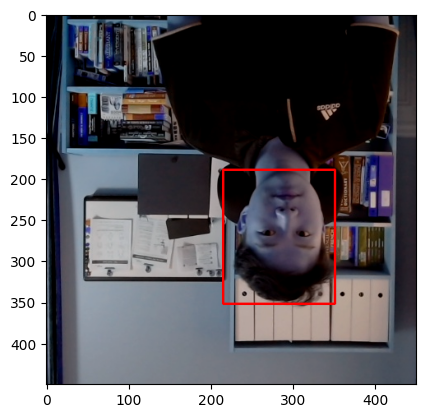

In [213]:
#Draw Boxes on Image
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

#Show Image with Box
plt.imshow(augmented['image'])

#  5. Run Augmentation Pipeline

In [ ]:
#For each data set
for partition in ['train','test','val']: 
    #For each image in each partition
    for image in os.listdir(os.path.join('data', partition, 'images')):
        #Read Image
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        #Default Annotation For Images Without
        coords = [0,0,0.00001,0.00001]

        #Find Corresponding Label
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        
        #If Label Exists
        if os.path.exists(label_path):

            #Load File
            with open(label_path, 'r') as f:
                label = json.load(f)

            #Extract Coordinates and Rescale to Match Image Resolution
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            #Creating 60 augmented images per base image
            for x in range(60): #Can change to other number
                #Run Data Through Augmentation Pipeline
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

                #Write Augmented Images Inside Aug Data Folder
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                #Create Annotation Variable
                annotation = {}
                annotation['image'] = image

                #Copy Box Annotations
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 

                #Write Label for New Image
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [416]:
#Load Training Image Set
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) #Resizing to 120x120 to make more efficient Neural Network
train_images = train_images.map(lambda x: x/255) #Rescaling Image so can apply sigmoid activation

In [417]:
#Load Testing Image Set
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120))) #Resizing to 120x120 to make more efficient Neural Network
test_images = test_images.map(lambda x: x/255) #Rescaling Image so can apply sigmoid activation

In [418]:
#Load Validation Image Set
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120))) #Resizing to 120x120 to make more efficient Neural Network
val_images = val_images.map(lambda x: x/255) #Rescaling Image so can apply sigmoid activation

In [218]:
train_images.as_numpy_iterator().next()

array([[[9.8039216e-01, 9.8425245e-01, 9.7107846e-01],
        [9.8039216e-01, 9.8823529e-01, 9.7450978e-01],
        [9.6770835e-01, 9.8339462e-01, 9.8694855e-01],
        ...,
        [1.2071079e-02, 1.2071079e-02, 4.2279414e-03],
        [1.9607844e-02, 1.9607844e-02, 1.1764706e-02],
        [2.1691177e-02, 2.4448529e-02, 1.2928922e-02]],

       [[9.8039216e-01, 9.8431373e-01, 9.6470588e-01],
        [9.8045343e-01, 9.8480392e-01, 9.6519607e-01],
        [9.8100489e-01, 9.8884803e-01, 9.7610295e-01],
        ...,
        [8.3333338e-03, 1.6176471e-02, 4.4117649e-03],
        [1.6176471e-02, 1.7034315e-02, 8.7622553e-03],
        [1.8627452e-02, 2.1262255e-02, 5.5147060e-03]],

       [[9.8431373e-01, 9.8823529e-01, 9.6862745e-01],
        [9.8431373e-01, 9.8823529e-01, 9.6862745e-01],
        [9.8088235e-01, 9.8480392e-01, 9.6519607e-01],
        ...,
        [4.4117649e-03, 1.2254902e-02, 4.9019611e-04],
        [1.8627452e-02, 2.3039216e-02, 4.4117649e-03],
        [2.2242647e-02

# 6. Prepare Labels

In [423]:
#Label Loading Function
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [424]:
def set_shapes(cls, bbox):
    cls.set_shape([1])
    bbox.set_shape([4])
    return cls, bbox

In [425]:
#Load Labels to Tensorflow Dataset

train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels = train_labels.map(set_shapes)

test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = test_labels.map(set_shapes)

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = val_labels.map(set_shapes)

In [427]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1638, 0.2173, 0.52  , 0.626 ], dtype=float16))

#  7. Combine Label and Image Samples

In [428]:
#Checking Dataset Size
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4980, 4980, 1020, 1020, 1020, 1020)

In [429]:
#Create Final Image/Label Dataset
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [430]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 4), dtype=tf.float16, name=None)))>

In [431]:
#Create Final Image/Label Dataset
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [432]:
#Create Final Image/Label Dataset
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [433]:
train.as_numpy_iterator().next()

(array([[[[0.43553922, 0.19914216, 0.20269608],
          [0.04589461, 0.02175245, 0.01403186],
          [0.02487745, 0.04460784, 0.04718137],
          ...,
          [0.03106618, 0.07028186, 0.16832107],
          [0.17775735, 0.19148284, 0.25226715],
          [0.27818626, 0.2454044 , 0.2202206 ]],
 
         [[0.4779412 , 0.3447304 , 0.3783701 ],
          [0.03694853, 0.02285539, 0.03670343],
          [0.0435049 , 0.04264706, 0.04307598],
          ...,
          [0.0382353 , 0.08529412, 0.1872549 ],
          [0.16433823, 0.17414215, 0.23639706],
          [0.30692402, 0.26819852, 0.25398284]],
 
         [[0.49938726, 0.5419118 , 0.58682597],
          [0.        , 0.03982843, 0.06053922],
          [0.04313726, 0.03627451, 0.04056372],
          ...,
          [0.05116422, 0.09724265, 0.19883579],
          [0.159375  , 0.1583946 , 0.21623774],
          [0.34987745, 0.30569854, 0.27585784]],
 
         ...,
 
         [[0.7519608 , 0.7088235 , 0.6901961 ],
          [0.76764

In [434]:
#View Images and Annotations

#Prepare Samples
data_samples = train.as_numpy_iterator()

In [435]:
#Grab Next Batch
res = data_samples.next()

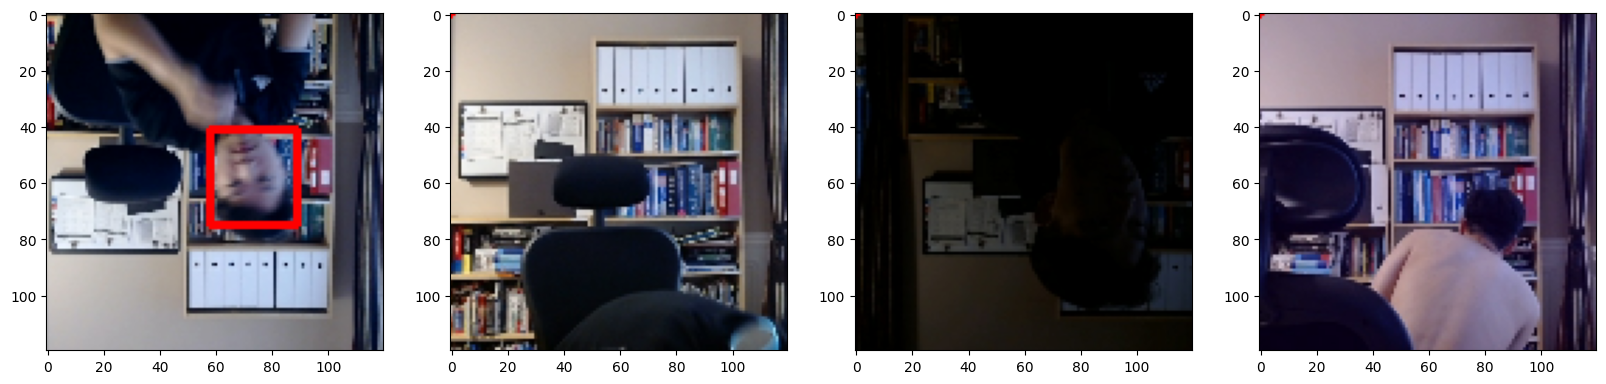

: 

In [500]:
#Plot out all samples

#4 Plots 20x20
fig, ax = plt.subplots(ncols=4, figsize=(20,20))

#For each plot
for idx in range(4):     

    #Get Image
    sample_image = res[0][idx]

    #Get Bound
    sample_coords = res[1][1][idx]

    sample_image = sample_image.copy()
    
    #Create Rectangle
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    #Show Image
    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using Functional API

In [437]:
#Import Layers and Base Network
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [438]:
#Download VGG16
vgg = VGG16(include_top=False) #Remove Top Layer As We Will Put Our Own

In [439]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [440]:
#Build Instance of Network

def build_model(): 
    #Configure Input Layer
    input_layer = Input(shape=(120,120,3)) #120px by 120px by 3 colours
    
    #Build VGG16 - Huge Pretrained Model
    vgg = VGG16(include_top=False)(input_layer)

    #Classification Model  
    f1 = GlobalMaxPooling2D()(vgg) #Reduces spatial dimensions of feature map by taking max values of all elements in each feature map
    class1 = Dense(2048, activation='relu')(f1) #Resulting 1D of previous step
    class2 = Dense(1, activation='sigmoid')(class1) #Fully connected layer with 1 neuron and sigmoid activation function (binary classification)
    
    #Bounding box model (Regression)
    f2 = GlobalMaxPooling2D()(vgg) #Reduces spatial dimensions of feature map by taking max values of all elements in each feature map
    regress1 = Dense(2048, activation='relu')(f2) #Resulting 1D of previous step
    regress2 = Dense(4, activation='sigmoid')(regress1) #Fully connected layer with 4 neurons and sigmoid activation function (4 output values for box vertices)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [441]:
#Test out Neural Network
facetracker = build_model()

In [442]:
facetracker.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │      2,049 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 4)         │      8,196 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [443]:
#Grab Image and Lab
x,y  =  train.as_numpy_iterator().next()

In [444]:
y[1]

array([[0.2223, 0.286 , 0.5957, 0.7354],
       [0.8306, 0.2305, 1.    , 0.6445],
       [0.1238, 0.2329, 0.5054, 0.6367],
       [0.3435, 0.4011, 0.725 , 0.8047],
       [0.8022, 0.4685, 1.    , 0.918 ],
       [0.    , 0.    , 0.    , 0.    ],
       [0.501 , 0.1636, 1.    , 0.9033],
       [0.1167, 0.2554, 0.4136, 0.598 ]], dtype=float16)

In [445]:
#Prediction (Unfinished Model so Really Bad)
classes, coords = facetracker.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [446]:
classes, coords

(array([[0.5979005 ],
        [0.6217828 ],
        [0.6361482 ],
        [0.55060965],
        [0.54648614],
        [0.5274747 ],
        [0.650086  ],
        [0.62158656]], dtype=float32),
 array([[0.38272032, 0.3734681 , 0.41139737, 0.25791466],
        [0.3326697 , 0.517658  , 0.4730316 , 0.29372776],
        [0.42700624, 0.49268764, 0.45581985, 0.22170345],
        [0.4682783 , 0.35456762, 0.46657845, 0.34877226],
        [0.3869907 , 0.42682207, 0.44428304, 0.42446345],
        [0.34457317, 0.4566767 , 0.48297772, 0.33382156],
        [0.4371238 , 0.4297771 , 0.4052392 , 0.3391244 ],
        [0.39257112, 0.50163865, 0.43642953, 0.2543114 ]], dtype=float32))

# 9. Define Losses and Optimizers

In [449]:
#Define Learning Rate
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [450]:
#Define Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [451]:
#Create Localization and Classification Loss

def localization_loss(y_true, yhat):            
    #Function is based on formula from https://stats.stackexchange.com/questions/287486/yolo-loss-function-explanation

    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [452]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [453]:
#Test Loss Metrics
localization_loss(y[1], coords).numpy() #Test Localization Loss

4.6362257

In [454]:
classloss(y[0], classes).numpy() #Test Classification Loss

0.53732365

In [455]:
regressloss(y[1], coords).numpy() #Test Regression Loss

4.6362257

# 10. Train Neural Network

In [458]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [457]:
#Create Custom Model Class

class FaceTracker(Model): 
    #Pass Initial Parameters (Hyperparameters)
    def __init__(self, facetracker,  **kwargs): #Pass In Pre-built Facetracker Model 
        super().__init__(**kwargs)
        self.model = facetracker

    #Pass in optimizer, classification loss and localization loss
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    #Take in One Batch and Train On Batch
    def train_step(self, batch, **kwargs): 

        #Take Data and Get X and Y Values
        x, y = batch
        
        #Calculate each of the different functions being applied
        with tf.GradientTape() as tape: 

            #Make a prediction with X value
            classes, coords = self.model(x, training=True) #Training = True so if there's any layers that perform differently, will activate
            
            #Returned classes and coordinates get passed through loss functions
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)  #Casting to float32 to make sure loss works
            
            #Calculate total loss
            total_loss = batch_localizationloss+0.5*batch_classloss #Can tweak total_loss formula
            
            #Calculate Gradient
            grad = tape.gradient(total_loss, self.model.trainable_variables) #Calculating with respect to loss function
        
        #Gradient Descent
        opt.apply_gradients(zip(grad, self.model.trainable_variables)) #Loop through and apply one step of gradient descent
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        
        #Take Data and Get X and Y Values
        x, y = batch

        #Make a prediction with X value
        classes, coords = self.model(x, training=False) #Training = False so model will not change
        

        #Pass classes, coords through loss functions
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

        #Calculate Total Loss
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        

    
    #Allows us to use .predict
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [459]:
#Create Model
model = FaceTracker(facetracker)

In [460]:
#Compile Model
model.compile(opt, classloss, regressloss)

In [461]:
#Train Model

#Log Directory
logdir = 'logs'

In [462]:
#Create tensorboard log directory
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [463]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 4), dtype=tf.float16, name=None)))>

In [464]:
#Start Training Model With Training Data
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])  #Train for 10 epochs, validation data = val, callbacks to tensorboard_callback
#hist variable will allow to get training history

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 1211s 2s/step - class_loss: 0.0633 - regress_loss: 0.1945 - total_loss: 0.2261 - val_class_loss: 0.0014 - val_regress_loss: 0.0890 - val_total_loss: 0.0896
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 1148s 2s/step - class_loss: 0.0156 - regress_loss: 0.0526 - total_loss: 0.0604 - val_class_loss: 1.5659e-04 - val_regress_loss: 0.0159 - val_total_loss: 0.0160
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 1130s 2s/step - class_loss: 0.0111 - regress_loss: 0.0396 - total_loss: 0.0452 - val_class_loss: 7.0550e-05 - val_regress_loss: 0.0173 - val_total_loss: 0.0173
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 1123s 2s/step - class_loss: 0.0311 - regress_loss: 0.0886 - total_loss: 0.1042 - val_class_loss: 6.0821e-05 - val_regress_loss: 0.0243 - val_total_loss: 0.0243
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 1138s 2s/step - class_loss: 0.0255 - regress_loss: 0.0724 - total_loss: 0.0851 - val_class_loss: 0.0372 - val_regress_loss: 0.0101 - val_total_loss: 0.0288
Epoch 6/

In [465]:
#Get History
hist.history

{'class_loss': [0.0032665138132870197,
  0.0003621369833126664,
  4.0926144720287994e-05,
  0.0024325798731297255,
  0.010442951694130898,
  0.0003034540277440101,
  6.518690497614443e-05,
  0.007987601682543755,
  0.0004966570995748043,
  0.0006811799248680472],
 'regress_loss': [0.0109062185510993,
  0.0032816361635923386,
  0.013614910654723644,
  0.10430556535720825,
  0.011960944160819054,
  0.0014563879230991006,
  0.0026361793279647827,
  0.005098617635667324,
  0.022984573617577553,
  0.011344065889716148],
 'total_loss': [0.012539475224912167,
  0.003462704597041011,
  0.013635373674333096,
  0.10552185773849487,
  0.017182420939207077,
  0.0016081149224191904,
  0.0026687728241086006,
  0.009092418476939201,
  0.023232901468873024,
  0.011684656143188477],
 'val_class_loss': [0.001373759121634066,
  0.00015659385826438665,
  7.054980960674584e-05,
  6.082056279410608e-05,
  0.03724044933915138,
  0.00031875367858447134,
  0.00030826154397800565,
  0.00039206433575600386,
  0.

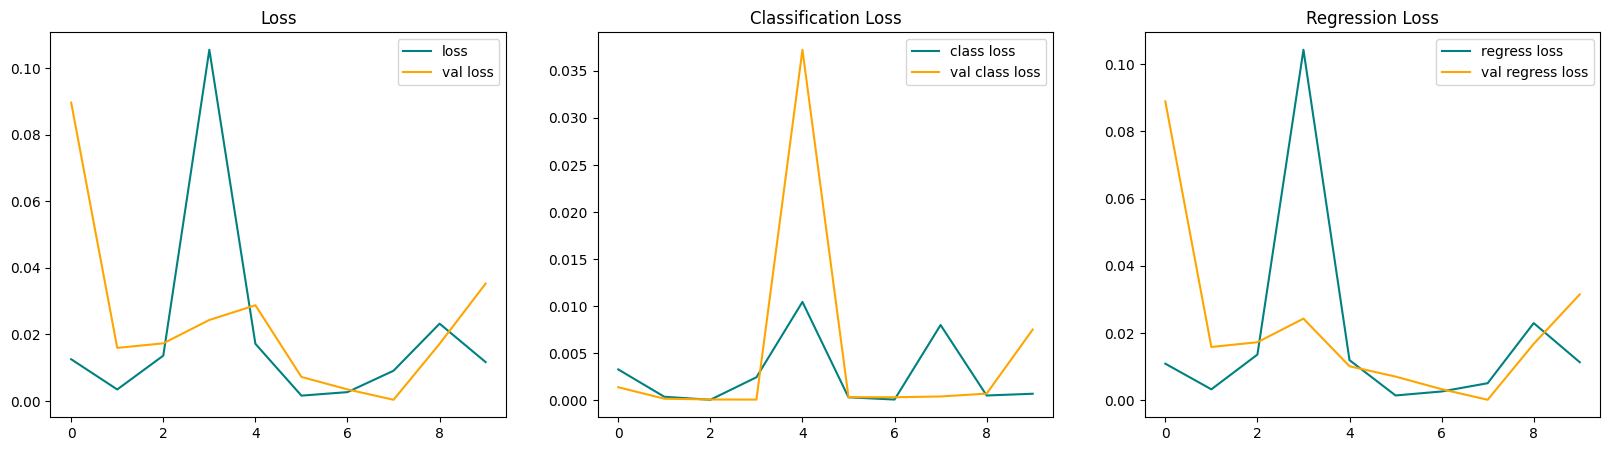

In [466]:
#Plot 3 Plots 20x5
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

#Plot Total Loss Against Validation Loss
ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

#Plot Classification Loss Against Validation Class Lost
ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

#Plot Regression Loss Against Validation Regression Loss
ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

In [487]:
#Set Up Iterator
test_data = test.as_numpy_iterator()

In [491]:
#Grab One Batch of Data
test_sample = test_data.next()

In [492]:
#Make Prediction Using Test
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step


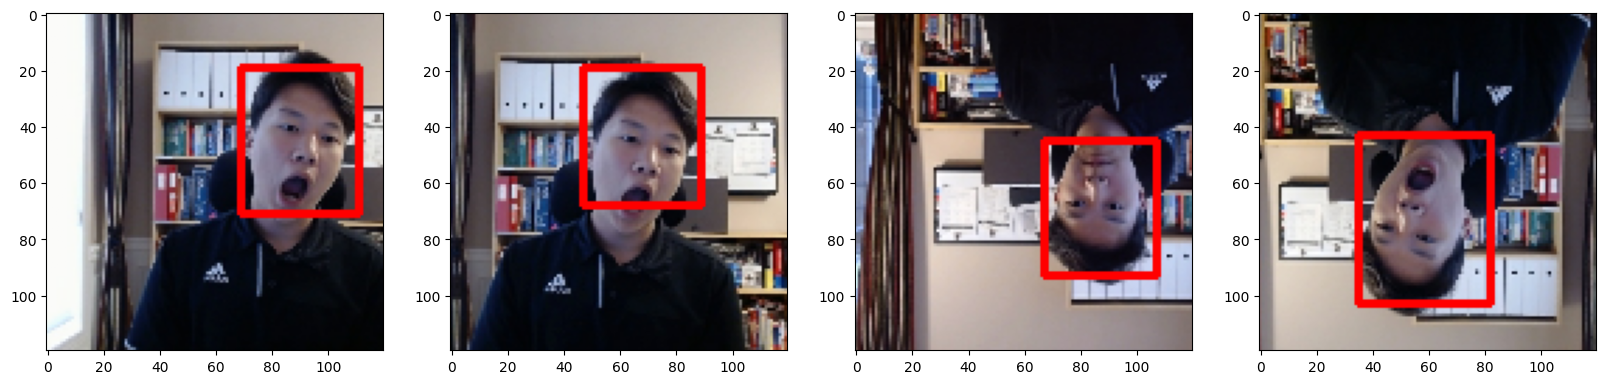

In [493]:
#Make 4 plots 20x20
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#For Each Image
for idx in range(4):

    #Take Image and Coordinates
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    #Make Copy to Fix Read-Only
    sample_image = sample_image.copy()

    #Draw Rectangle
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    #Display Image
    ax[idx].imshow(sample_image)

In [496]:
#Save the Model
from tensorflow.keras.models import load_model

In [497]:
#Save Model in File
facetracker.save('facetracker.keras')

In [498]:
#Load Model
facetracker = load_model('facetracker.keras')

In [499]:
#Real Time Detection

#Intialize Video Camera
cap = cv2.VideoCapture(1)

#While Open
while cap.isOpened():
    
    #Read Frames
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    #Read Colours and Size
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    #Predict Using Model
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    
    #Get Coords Using Model
    sample_coords = yhat[1][0]
    
    #Draw Rectangle
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('Facetrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 